In [1]:
import pandas as pd
import numpy as np
import pickle
import random

import igraph as ig
import hypernetx as hnx
import hypernetx.algorithms.hypergraph_modularity as hmod
import hypernetx.algorithms.generative_models as gm
import matplotlib.pyplot as plt

import shutup
shutup.mute_warnings()

# Main functions for Hypergraph Modularity using HyperNetX


### hypergraph modularity (qH)

The function to compute the h-modularity of hypergraph H with respect to a partition A (list of sets covering the vertices):

```python
hmod.hypergraph_modularity(H, A, wcd=hmod.linear)
```

where 'wcd' is the weight function (default = 'linear'). Other choices are 'strict'
and 'majority', or any user-supplied function with the following format:

```python
def quad(d,c):
    return (c/d)**2 if c>d/2 else 0
hmod.hypergraph_modularity(H, A, wcd=quad)
```

where $d$ is the edge size, and $c$ is the number of nodes in the majority class, $d \geq c > \frac{d}{2}$

### Two-section graph

Build the random-walk based $2$-section graph given some hypergraph H:

```python
G = hmod.two_section(H)
```

where G is an igraph graph.

### Clustering: Kumar algorithm

Given hypergraph H, compute a partition of the vertices as per Kumar's algorithm described in [1].

```python
K = hmod.kumar(H, delta=.01)
```

where delta is the convergence stopping criterion. Partition is returned as a list of sets.

[1] Kumar T., Vaidyanathan S., Ananthapadmanabhan H., Parthasarathy S., Ravindran B. (2020) *A New Measure of Modularity in Hypergraphs: Theoretical Insights and Implications for Effective Clustering*. In: Cherifi H., Gaito S., Mendes J., Moro E., Rocha L. (eds) Complex Networks and Their Applications VIII. COMPLEX NETWORKS 2019. Studies in Computational Intelligence, vol 881. Springer, Cham. https://doi.org/10.1007/978-3-030-36687-2_24


### Clustering: Simple qH-based algorithm

Given hypergraph H and initial partition A, compute a partition of the vertices as per Last-Step algorithm described in [2].

```python
A = hmod.last_step(H, A, wdc=hmod.linear, delta = .01)
```

where 'wcd' is the the weight function (default = 'linear') and delta is the convergence stopping criterion.
Returned partition is a list of sets.

[2] Kamiński B., Prałat P. and Théberge F. “Community Detection Algorithm Using Hypergraph Modularity”. In: Benito R.M., Cherifi C., Cherifi H., Moro E., Rocha L.M., Sales-Pardo M. (eds) Complex Networks & Their Applications IX. COMPLEX NETWORKS 2020. Studies in Computational Intelligence, vol 943. Springer, Cham. https://doi.org/10.1007/978-3-030-65347-7_13

### Utility functions

We use two representations for partitions: list of sets (the parts) or dictionary.
Those functions are used to map from one to the other:

```python
hmod.dict2part(D)
hmod.part2dict(A)
```

# Toy example

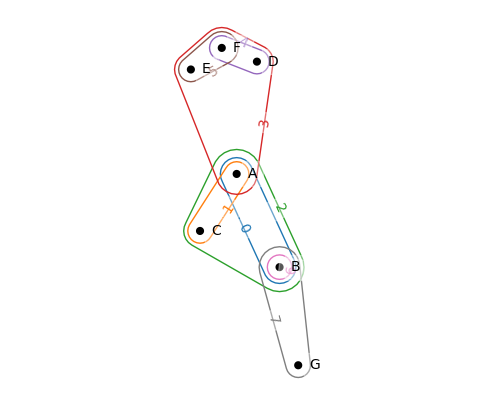

In [2]:
## build a hypergraph from a list of sets (the hyperedges)
E = [{'A','B'},{'A','C'},{'A','B','C'},{'A','D','E','F'},{'D','F'},{'E','F'},{'B'},{'G','B'}]
kwargs = {'layout_kwargs': {'seed': 42}, 'with_node_counts': False}
Toy = hnx.Hypergraph(dict(enumerate(E)))
# for e in HG.edges:
#     Toy.edges[e].weight = 1.0
plt.figure(figsize=(6,5))
hnx.draw(Toy, **kwargs)


# hypergraph modularity qH

We compute qH on the toy graph for 4 different partitions, and using different variations for the edge contribution.

For edges of size $d$ where $c$ is the number of nodes from the part with the most representatives, we consider  variations as follows for edge contribution:

* **strict**: edges are considered only if all nodes are from the same part, with unit weight, i.e. $w$ = 1 iff $c == d$ (0 else).
* **cubic**: edges are counted only if more that half the nodes are from the same part, with weights proportional to the cube of the number of nodes in the majority, i.e. $w = (c/d)^3$ iff $c>d/2$ (0 else).
* **quadratic**: edges are counted only if more that half the nodes are from the same part, with weights proportional to the square of the number of nodes in the majority, i.e. $w = (c/d)^2$ iff $c>d/2$ (0 else).
* **linear**: edges are counted only if more that half the nodes are from the same part, with weights proportional to the number of nodes in the majority, i.e. $w = c/d$ iff $c>d/2$ (0 else).
* **majority**: edges are counted only if more that half the nodes are from the same part, with unit weights, i.e. $w$ = 1 iff $c>d/2$ (0 else).

Some of the above are supplied with the `hmod` module, the **qH2** and **qH3** functions are examples of user-supplied choice.

The order above goes from only counting "pure" edges as community edges, gradually giving more weight to edges with $c>d/2$, all the way to giving the the same weights.

    


In [3]:
## Examples of user-supplied weight functions 
## square modularity 
def qH2(d,c):
    return (c/d)**2 if c > d/2 else 0
## cubic modularity
def qH3(d,c):
    return (c/d)**3 if c > d/2 else 0

## compute hypergraph modularity (qH) for the following partitions:
A1 = [{'A','B','C','G'},{'D','E','F'}]            ## good clustering, qH should be positive
A2 = [{'B','C'},{'A','D','E','F','G'}]            ## not so good
A3 = [{'A','B','C','D','E','F','G'}]              ## this should yield qH == 0
A4 = [{'A'},{'B'},{'C'},{'D'},{'E'},{'F'},{'G'}]  ## qH should be negative here

## we compute with different choices of functions for the edge contribution

print('strict edge contribution:')
print('qH(A1):',"{:.4f}".format(hmod.modularity(Toy,A1,hmod.strict)),
      'qH(A2):',"{:.4f}".format(hmod.modularity(Toy,A2,hmod.strict)),
      'qH(A3):',"{:.4f}".format(hmod.modularity(Toy,A3,hmod.strict)),
      'qH(A4):',"{:.4f}".format(hmod.modularity(Toy,A4,hmod.strict)))
print('\ncubic edge contribution:')
print('qH(A1):',"{:.4f}".format(hmod.modularity(Toy,A1,qH3)),
      'qH(A2):',"{:.4f}".format(hmod.modularity(Toy,A2,qH3)),
      'qH(A3):',"{:.4f}".format(hmod.modularity(Toy,A3,qH3)),
      'qH(A4):',"{:.4f}".format(hmod.modularity(Toy,A4,qH3)))
print('\nquadratic edge contribution:')
print('qH(A1):',"{:.4f}".format(hmod.modularity(Toy,A1,qH2)),
      'qH(A2):',"{:.4f}".format(hmod.modularity(Toy,A2,qH2)),
      'qH(A3):',"{:.4f}".format(hmod.modularity(Toy,A3,qH2)),
      'qH(A4):',"{:.4f}".format(hmod.modularity(Toy,A4,qH2)))
print('\nlinear edge contribution:')
print('qH(A1):',"{:.4f}".format(hmod.modularity(Toy,A1,hmod.linear)),
      'qH(A2):',"{:.4f}".format(hmod.modularity(Toy,A2,hmod.linear)),
      'qH(A3):',"{:.4f}".format(hmod.modularity(Toy,A3,hmod.linear)),
      'qH(A4):',"{:.4f}".format(hmod.modularity(Toy,A4,hmod.linear)))
print('\nmajority edge contribution:')
print('qH(A1):',"{:.4f}".format(hmod.modularity(Toy,A1,hmod.majority)),
      'qH(A2):',"{:.4f}".format(hmod.modularity(Toy,A2,hmod.majority)),
      'qH(A3):',"{:.4f}".format(hmod.modularity(Toy,A3,hmod.majority)),
      'qH(A4):',"{:.4f}".format(hmod.modularity(Toy,A4,hmod.majority)));


strict edge contribution:
qH(A1): 0.3659 qH(A2): -0.0401 qH(A3): 0.0000 qH(A4): -0.1088

cubic edge contribution:
qH(A1): 0.3659 qH(A2): -0.0538 qH(A3): 0.0000 qH(A4): -0.1291

quadratic edge contribution:
qH(A1): 0.3615 qH(A2): -0.0563 qH(A3): 0.0000 qH(A4): -0.1384

linear edge contribution:
qH(A1): 0.3535 qH(A2): -0.0586 qH(A3): 0.0000 qH(A4): -0.1520

majority edge contribution:
qH(A1): 0.3394 qH(A2): -0.0602 qH(A3): 0.0000 qH(A4): -0.1721


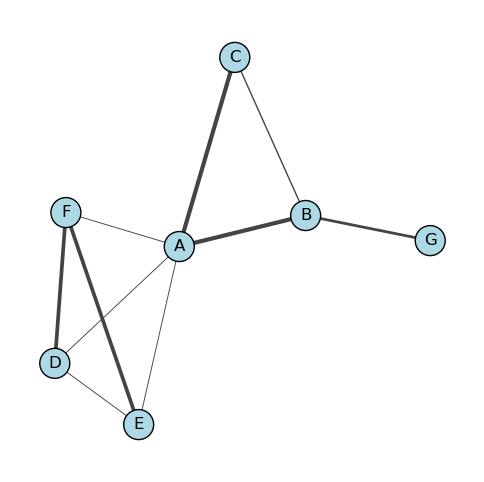

In [4]:
## 2-section graph
G = hmod.two_section(Toy)
G.vs['label'] = G.vs['name']
fig, ax = plt.subplots(figsize=(6,6))
ig.plot(G, target=ax, vertex_color='lightblue',edge_width = 2*np.array(G.es['weight']));

### clustering the toy graph

Looking at the plots above, we see a 4-clique for the 2-section graph, which most graph clustering algorithms should recover as a part if edge weights are ignored. 
However, looking at the hypergraph itself, nodes A-B-C are more tightly connected, and a hypergraph-based algorithm is likely to keep those together.


In [5]:
## 2-section clustering with Leiden - ignoring edge weights
G.vs['community'] = G.community_leiden(objective_function='modularity').membership
hmod.dict2part({v['name']:v['community'] for v in G.vs})


[{'A', 'D', 'E', 'F'}, {'B', 'C', 'G'}]

In [6]:
## 2-section clustering with Leiden - with edge weights
G.vs['community'] = G.community_leiden(objective_function='modularity', weights='weight').membership
hmod.dict2part({v['name']:v['community'] for v in G.vs})


[{'A', 'B', 'C', 'G'}, {'D', 'E', 'F'}]

In [7]:
## Clustering with Kumar's algorithm
hmod.kumar(Toy)


[{'A', 'B', 'C', 'G'}, {'D', 'E', 'F'}]

In [8]:
## hypergraph clustering -- start from trivial partition A4 defined above
print('start from:', A4)
A = hmod.last_step(Toy, A4)
A = [s for s in A if len(s)>0] ## drop empty parts
print('final partition:',A)


start from: [{'A'}, {'B'}, {'C'}, {'D'}, {'E'}, {'F'}, {'G'}]
final partition: [{'A', 'G', 'B', 'C'}, {'F', 'E', 'D'}]


# Chung-Lu hypergraph example

We build a Chung-Lu hypergraph and compute modularity for partitions from 3 algorithms:
* Louvain, on the 2-section graph
* Kumar algorithm
* LastStep algorithm

We use the **strict** modularity, so only edges where all vertices are in the same part will add to the modularity.
For each algorithm, we compute the modularity qH and compare with the number of edges where all vertices are in the same part.


In [9]:
## Chung-Lu hypergraph
n = 200
k1 = {i : random.randint(2, 10) for i in range(n)}  ## node degrees
k2 = {i : sorted(k1.values())[i] for i in range(n)} ## edge sizes
CL = gm.chung_lu_hypergraph(k1, k2)


In [10]:
## Louvain algorithm on the 2-section graph
G = hmod.two_section(CL)
G.vs['louvain'] = G.community_multilevel().membership
D = {v['name']:v['louvain'] for v in G.vs}
ML = hmod.dict2part(D)

## Compute qH
print('qH =',hmod.modularity(CL, ML, hmod.strict))

## number of edges where all vertices belong to the same community
print('number of edges with all vertices in same part:',
      sum([len(set([D[v] for v in CL.edges[e]]))==1 for e in CL.edges()]))


qH = 0.045429807322317224
number of edges with all vertices in same part: 21


In [11]:
## Kumar algorithm
KU = hmod.kumar(CL)

## Compute qH
print('qH =',hmod.modularity(CL, KU, hmod.strict))

## number of edges where all vertices belong to the same community
print('edges with all vertices in same part:',
      sum([len(set([hmod.part2dict(KU)[v] for v in CL.edges[e]]))==1 for e in CL.edges()]))


qH = 0.19609939328802947
edges with all vertices in same part: 50


In [12]:
## Last-step algorithm using previous result as initial partition
LS = hmod.last_step(CL, KU, hmod.strict)

## Compute qH
print('qH =',hmod.modularity(CL, LS, hmod.strict))

## number of edges where all vertices belong to the same community
print('edges with all vertices in same part:',
      sum([len(set([hmod.part2dict(LS)[v] for v in CL.edges[e]]))==1 for e in CL.edges()]))


qH = 0.2162464329256197
edges with all vertices in same part: 54


# Game of Thrones scenes hypergraph

REF: https://github.com/jeffreylancaster/game-of-thrones

We built an hypergraph from the game of thrones scenes with he following elements:

* **Nodes** are characters in the series
* **Hyperedges** are groups of character appearing in the same scene(s)
* **Hyperedge weights** are total scene(s) duration in seconds involving those characters

We kept hyperedges with at least 2 characters.

We saved the following:

* *Edges*: list of sets where the nodes are 0-based integers represents as strings
* *Names*: dictionary; mapping of nodes to character names
* *Weights*: list; hyperedge weights (in same order as Edges)


In [13]:
## load the GoT dataset
Edges, Names, Weights = pickle.load(open( "../../hypernetx/utils/toys/GoT.pkl", "rb" ))
print(len(Names),'nodes and',len(Edges),'edges')


198 nodes and 1492 edges


### Build weighted GoT hypergraph 

In [14]:
## Nodes are represented as strings from '0' to 'n-1'
GoT= hnx.Hypergraph(dict(enumerate(Edges)))

## add edge weights
for e in GoT.edges:
    GoT.edges[e].weight = Weights[e]

## add full names
for v in GoT.nodes:
    GoT.nodes[v].name = Names[v]


### Modularity (qH) on a random partition

We use the default choice for the modularity (**linear** weights).
Result for the random partition should be close to 0 and can be negative.

In [15]:
## generate a random partition into K parts to compare results
K = 5
V = list(GoT.nodes)
p = np.random.choice(K, size=len(V))
RandPart = hmod.dict2part({V[i]:p[i] for i in range(len(V))})
## compute qH
print('qH =',hmod.modularity(GoT, RandPart))


qH = -0.005252473269330059


### Generate the 2-section graph and cluster with Louvain Algorithm


In [16]:
## build 2-section
G = hmod.two_section(GoT)

## Louvain algorithm
G.vs['louvain'] = G.community_multilevel(weights='weight').membership
ML = hmod.dict2part({v['name']:v['louvain'] for v in G.vs})

## Compute qH
print('qH =',hmod.modularity(GoT, ML))


qH = 0.5372359319251632


### Cluster hypergraph with Kumar's algorithm


In [17]:
## run Kumar's algorithm, get partition
KU = hmod.kumar(GoT)

## Compute qH
print('qH =',hmod.modularity(GoT, KU))


qH = 0.5351500884869287


### Cluster with simple H-based (Last Step) Algorithm

We use Louvain on the 2-section or Kumar algorithm for the initial partition

In [18]:
## H-based last step with Louvain parition already computed
LS = hmod.last_step(GoT, ML)

## Compute qH
print('qH =',hmod.modularity(GoT, LS))


qH = 0.544096004207156


### Example: show top degree nodes in same cluster as Daenerys Targaryen


In [19]:
## Index for the characters
inv_map = {v: k for k, v in Names.items()}
DT = inv_map['Daenerys Targaryen']

## DT's cluster
DT_part = hmod.part2dict(LS)[DT]

## Build dataframe: all nodes in DT_part
L = []
for n in LS[DT_part]:
    L.append([Names[n], GoT.degree(n)])
D = pd.DataFrame(L, columns=['character','degree'])

## show top members
D.sort_values(by='degree',ascending=False).head(5)


,character,degree
27,Daenerys Targaryen,232
2,Jorah Mormont,121
16,Missandei,95
30,Drogon,84
15,Grey Worm,83
